In [112]:
%reset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
#from imblearn.over_sampling import RandomOverSampler
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
#oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=10) #need for neural network and random forest
import pickle
import random


Read in data

In [118]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_15_100k'] = (data_by_HSA['beds_weekly'] > 15)*1

# remove HSAs that have missing data in specific columns

data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_11249/3165355871.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')


Functions

In [117]:
def merge_and_rename_data(data1, data2, on_column, suffix1, suffix2):
    merged_data = pd.merge(data1, data2, on=on_column, suffixes=('_'+suffix1, '_'+suffix2))

    new_column_names = [col.replace(f'_{on_column}_{suffix1}', f'_{suffix1}').replace(f'_{on_column}_{suffix2}', f'_{suffix2}') for col in merged_data.columns]
    merged_data.rename(columns=dict(zip(merged_data.columns, new_column_names)), inplace=True)

    return merged_data

def pivot_data_by_HSA(data, index_column, columns_column, values_column):
    data_by_HSA = data[[index_column, columns_column, values_column]]
    pivot_table = data_by_HSA.pivot_table(index=index_column, columns=columns_column, values=values_column)
    return pivot_table

def create_column_names(categories_for_subsetting, num_of_weeks):
    column_names = ['HSA_ID']

    for week in range(1, num_of_weeks + 1):
        week = num2words(week)
        for category in categories_for_subsetting:
            column_name = f'week_{week}_{category}'
            column_names.append(column_name)

    return column_names
    
def create_collated_weekly_data(pivoted_table, original_data, categories_for_subsetting, geography, column_names):
    collated_data = pd.DataFrame(index=range(51), columns=column_names)

    x = 0
    for geo in original_data[geography].unique():
        #matching_indices = [i for i, geo_col in enumerate(pivoted_table) if geo_col == geo]
        collated_data.loc[x, geography] = geo
        columns_to_subset = [f'{geo}_{category}' for category in categories_for_subsetting]
        j = 1
        try:
            for row in range(len(pivoted_table.loc[:, columns_to_subset])):
                collated_data.iloc[x, j:j + len(categories_for_subsetting)] = pivoted_table.loc[row, columns_to_subset]
                j += len(categories_for_subsetting)
        except:
            pass
        x += 1

    return collated_data

def add_changes_by_week(weekly_data_frame, outcome_column):

    for column in weekly_data_frame.columns[1:]:
        # Calculate the difference between each row and the previous row
        if outcome_column not in column.lower(): #want to leave out the outcome column
            diff = weekly_data_frame[column].diff()
            
            # Create a new column with the original column name and "delta"
            new_column_name = column + "_delta"
            
            column_index = weekly_data_frame.columns.get_loc(column)
            
            # Insert the new column just after the original column
            weekly_data_frame.insert(column_index + 1, new_column_name, diff)
            weekly_data_frame[new_column_name] = diff
    return weekly_data_frame

def prep_training_test_data_period(data, no_weeks, weeks_in_future, geography, weight_col, keep_output):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    y_weeks_to_check = [] #check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append('_' + num2words(week) + '_')
        for week_y in range(week+1, test_week+1):
                y_weeks_to_check.append('_' + num2words(week_y) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
            train_week = w2n.word_to_num(x_week.replace("_", ""))
            target_week =  w2n.word_to_num(y_week.replace("_", ""))
            y_weeks_to_check = []
            for week_to_check in range(train_week + 1, target_week + 1):
                y_weeks_to_check.append('_' + num2words(week_to_check) + '_')

            y_weeks_to_check = [week + 'beds_over_15_100k' for week in y_weeks_to_check]
            columns_to_check = [col for col in data.columns if any(week in col for week in y_weeks_to_check)]
            y_over_in_period = data[columns_to_check].apply(max, axis=1)
            data_y = pd.concat([data_y, y_over_in_period], axis=1)
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)

            weights = X_week.iloc[:, -1] 
            if keep_output:
                X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and leave "target" for that week

                #rename columns for concatenation 
                X_week.columns = range(1, len(data_x.columns) -1)
            else:
                X_week = X_week.iloc[:, :len(X_week.columns)-2] # remove the weights and  "target" for that week

                X_week.columns = range(1, len(data_x.columns) -2)# remove the weights and  "target" for that week

            y_week.columns = range(1, len(data_y.columns) -2)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)


### this code it's ANY in the x week period 
def prep_training_test_data(data, no_weeks, weeks_in_future,geography, weight_col, keep_output):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append('_' + num2words(week) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k += 1
            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)

            weights = X_week.iloc[:, -1] 
            if keep_output:
                X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and leave "target" for that week

                #rename columns for concatenation 
                X_week.columns = range(1, len(data_x.columns) -1)
            else:
                X_week = X_week.iloc[:, :len(X_week.columns)-2] # remove the weights and  "target" for that week

                X_week.columns = range(1, len(data_x.columns) -2)# remove the weights and  "target" for that week

                #rename columns for concatenation 
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)


def calculate_ppv_npv(true_labels, predicted_labels):
    # Make sure the inputs have the same length
    if len(true_labels) != len(predicted_labels):
        raise ValueError("The true_labels and predicted_labels should have the same length.")

    true_positives = sum(1 for true_label, predicted_label in zip(true_labels, predicted_labels) if true_label == 1 and predicted_label == 1)
    false_positives = sum(1 for true_label, predicted_label in zip(true_labels, predicted_labels) if true_label == 0 and predicted_label == 1)
    true_negatives = sum(1 for true_label, predicted_label in zip(true_labels, predicted_labels) if true_label == 0 and predicted_label == 0)
    false_negatives = sum(1 for true_label, predicted_label in zip(true_labels, predicted_labels) if true_label == 1 and predicted_label == 0)

    ppv = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    npv = true_negatives / (true_negatives + false_negatives) if (true_negatives + false_negatives) > 0 else 0.0

    return ppv, npv

Rename weeks so 7/10/2022 is the first

In [119]:
for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i

Create dataframe

In [120]:
## pivot 
data_by_HSA_cases = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_deaths = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'deaths_weekly')
data_by_HSA_admissions = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_icu = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'icu_weekly')
data_by_HSA_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_weekly')
data_by_HSA_percent_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_over_15_100k = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_over_15_100k')

## merge 
data_by_HSA_cases_deaths = merge_and_rename_data(data_by_HSA_cases, data_by_HSA_deaths,'week','cases', 'deaths')
data_by_HSA_admits_icu_weekly = merge_and_rename_data(data_by_HSA_admissions, data_by_HSA_icu,'week','admits', 'icu')
data_by_HSA_beds_perc_weekly = merge_and_rename_data(data_by_HSA_beds, data_by_HSA_percent_beds,'week','beds', 'perc_covid')
data_by_HSA_cases_deaths_admits_icu = pd.merge(data_by_HSA_cases_deaths, data_by_HSA_admits_icu_weekly, on='week')
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu, data_by_HSA_beds_perc_weekly, on='week')

## add outcome variable 

old_column_names = data_by_HSA_over_15_100k.columns
new_column_names = [str(col) + '_beds_over_15_100k' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_over_15_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA_over_15_100k, on='week')

data_by_HSA_cases_deaths_admits_icu_beds = data_by_HSA_cases_deaths_admits_icu_beds.reset_index()
data_by_HSA_cases_deaths_admits_icu_beds.columns = data_by_HSA_cases_deaths_admits_icu_beds.columns.str.replace(',', '')

Add changes by week 

In [121]:
all_HSA_ID_weekly_data = add_changes_by_week(data_by_HSA_cases_deaths_admits_icu_beds, "beds_over_15_100k")

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_11249/864798172.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data_frame.insert(column_index + 1, new_column_name, diff)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_11249/864798172.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data_frame.insert(column_index + 1, new_column_name, diff)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_11249/864798172.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usu

In [122]:
categories_for_subsetting = ['cases', 'deaths', 'admits', 'icu', 'beds', 'perc_covid', 'cases_delta', 'deaths_delta', 'admits_delta', 'icu_delta', 'beds_delta', 'perc_covid_delta','beds_over_15_100k']
num_of_weeks = len(data_by_HSA_cases_deaths_admits_icu_beds)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

In [123]:

all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA, categories_for_subsetting, 'HSA_ID', column_names)

Add weights

In [124]:
weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

Get test/train dataset 
    - including "outcome" as a predictor 
    - not oversampling, using balanced weights
    - look at 3 week period rather than exactly three weeks

In [125]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_future = 3,   geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future = 3,   geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0].to_numpy()

Create decision tree

In [126]:
def cross_validation_leave_geo_out(data, geography_column, geo_split, no_iterations, cv, classifier, param_grid, no_iterations_param, no_weeks_train,no_weeks_test, weeks_in_future, weight_col, keep_output, time_period):
        best_hyperparameters_per_iter = []
        auROC_per_iter = []

        for i in range(no_iterations):
                #subset the HSAs from the full dataset 
                geo_names = data[geography_column].unique()
                num_names_to_select = int(geo_split * len(geo_names))
                geos_for_sample = random.sample(list(geo_names), num_names_to_select)
                subset_HSAs_for_train = data[data[geography_column].isin(geos_for_sample)]
                subset_HSAs_for_test = data[~data[geography_column].isin(geos_for_sample)]

                #create training and test data
                if time_period == 'period':
                        X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_train, no_weeks = no_weeks_train, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_test, no_weeks = no_weeks_test, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        weights_train = weights_train[0]
                elif time_period == 'exact':
                        X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_train, no_weeks = no_weeks_train, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col =weight_col,keep_output = keep_output)
                        X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_test, no_weeks = no_weeks_test, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        weights_train = weights_train[0]
                elif time_period == 'shifted':
                        X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_train, no_weeks = no_weeks_train, weeks_in_future = weeks_in_future, geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_test, no_weeks = no_weeks_test, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        weights_train = weights_train[0]
                        y_sample_train = y_sample_train.shift(-1)
                        y_sample_test = y_sample_test.shift(-1)

                        y_sample_train.drop(index=y_sample_train.index[-1], inplace=True)
                        y_sample_test.drop(index=y_sample_test.index[-1], inplace=True)

                        X_sample_train.drop(index=X_sample_train.index[-1], inplace=True)
                        X_sample_test.drop(index=X_sample_test.index[-1], inplace=True)

                        weights_train.drop(index=weights_train.index[-1], inplace=True)
                random_search = RandomizedSearchCV(classifier, param_grid, n_iter=no_iterations_param, cv=cv, random_state=10)
                random_search.fit(X_sample_train, y_sample_train, sample_weight = weights_train)
                best_params = random_search.best_params_

        # Create the Decision Tree classifier with the best hyperparameters
                model = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')
                model_fit = model.fit(X_sample_train, y_sample_train, sample_weight=weights_train)
                y_pred = model_fit.predict_proba(X_sample_test)
                # Evaluate the accuracy of the model
                best_hyperparameters_per_iter.append(best_params)
                auROC_per_iter.append(roc_auc_score(y_sample_test, y_pred[:,1]))
        
        return best_hyperparameters_per_iter[np.argmax(np.array(auROC_per_iter))]

Accuracy: 0.8113073487616728
auROC: 0.9091874097110433
[[ 5142   715]
 [ 4862 18837]]


[Text(0.44, 0.9, 'admits <= 20.396\nentropy = 0.941\nsamples = 64770\nvalue = [23.53, 42.261]'),
 Text(0.2, 0.7, 'admits <= 10.142\nentropy = 0.652\nsamples = 13157\nvalue = [21.085, 4.242]'),
 Text(0.08, 0.5, 'cases <= 20.5\nentropy = 0.445\nsamples = 8781\nvalue = [15.733, 1.602]'),
 Text(0.04, 0.3, 'entropy = 0.249\nsamples = 2157\nvalue = [5.521, 0.238]'),
 Text(0.12, 0.3, 'deaths <= 1.554\nentropy = 0.523\nsamples = 6624\nvalue = [10.212, 1.364]'),
 Text(0.08, 0.1, 'entropy = 0.41\nsamples = 3782\nvalue = [6.194, 0.554]'),
 Text(0.16, 0.1, 'entropy = 0.653\nsamples = 2842\nvalue = [4.018, 0.81]'),
 Text(0.32, 0.5, 'icu <= 8.5\nentropy = 0.915\nsamples = 4376\nvalue = [5.352, 2.639]'),
 Text(0.28, 0.3, 'cases <= 41.5\nentropy = 0.841\nsamples = 2953\nvalue = [4.739, 1.748]'),
 Text(0.24, 0.1, 'entropy = 0.787\nsamples = 1648\nvalue = [3.709, 1.142]'),
 Text(0.32, 0.1, 'entropy = 0.951\nsamples = 1305\nvalue = [1.03, 0.606]'),
 Text(0.36, 0.3, 'entropy = 0.975\nsamples = 1423\nvalue

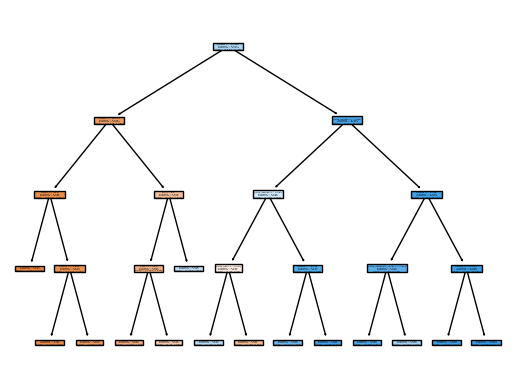

In [128]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
no_weeks_train =  range(1, int(123*2/3) + 1)  # across entire training period
no_weeks_test = range(int(123*2/3) + 1, 120) # across entire training period
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  
no_iterations_param = 10  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
# Perform Randomized Search with 10-fold cross-validation

best_params = cross_validation_leave_geo_out(all_HSA_ID_weekly_data, geography_column=geography_column, geo_split=geo_split, no_iterations=no_iterations, cv=cv, classifier=clf, param_grid=param_grid, no_iterations_param=no_iterations_param, no_weeks_train=no_weeks_train, no_weeks_test=no_weeks_test, weeks_in_future=weeks_in_future, weight_col=weight_col, keep_output=keep_output, time_period='period')

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
#plt.savefig('Graphs/Full_classifier_3_week_period_unpruned.png', dpi = 300)

Accuracy: 0.8113073487616728
auROC: 0.9091874097110433
[[ 5142   715]
 [ 4862 18837]]


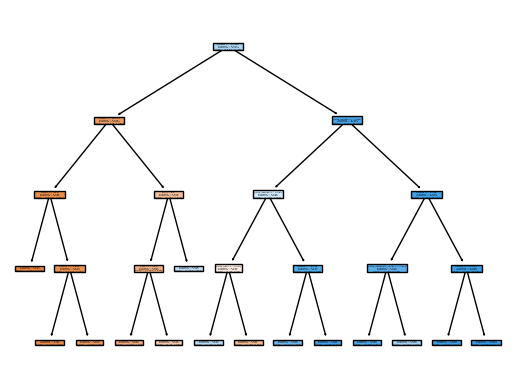

In [130]:
# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
#plt.savefig('Graphs/Full_classifier_3_week_period_unpruned.png', dpi = 300)

In [132]:
model_name = f"Full_auroc_{ROC:.4f}_period_unpruned.sav"
pickle.dump(clf, open(model_name, 'wb'))
#model_name =  "Full_auroc_0.9080_period_pruned.sav"
clf = pickle.load(open(model_name, 'rb'))

In [133]:
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])
print(accuracy)
print(ROC)


0.8113073487616728
0.9091874097110433


In [134]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

sensitivity:  0.7948436642896325
specificity:  0.8779238518012634
ppv:  0.9634308510638298
npv:  0.5139944022391043


Now look at each week in the three week period - which one has the best preedictive capacity? 

In [66]:
### this code it's exactly in  x weeks 
def prep_training_test_data(data, no_weeks, weeks_in_future,geography, weight_col):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append('_' + num2words(week) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')

    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]

            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)

            weights = X_week.iloc[:, -1] 
            X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and leave "target" for that week, inlcuding it as a feature

            #rename columns for concatenation 
            X_week.columns = range(1, len(data_x.columns) -1)
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)



In [141]:
weeks_to_predict = range(0,4)
ROC_by_week = []
#
for prediction_week in weeks_to_predict: 
    
    X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_future = prediction_week,   geography = 'HSA_ID', weight_col = 'weight')

    X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 122), weeks_in_future = prediction_week,   geography = 'HSA_ID',  weight_col = 'weight')
    weights = weights[0]
    clf.fit(X_train, y_train[0],  sample_weight = weights)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test[0], y_pred)
    ROC_by_week.append(roc_auc_score(y_test[0], y_pred))

In [40]:

#pickle.dump(clf, open(model_name, 'wb'))
clf = pickle.load(open(model_name, 'rb'))

In [56]:
best_params = {'criterion':'entropy',
                       'max_depth':5, 'min_samples_leaf':480, 'min_samples_split':540}

Number of nodes in the last tree is: 3 with ccp_alpha: 0.47425105382425436


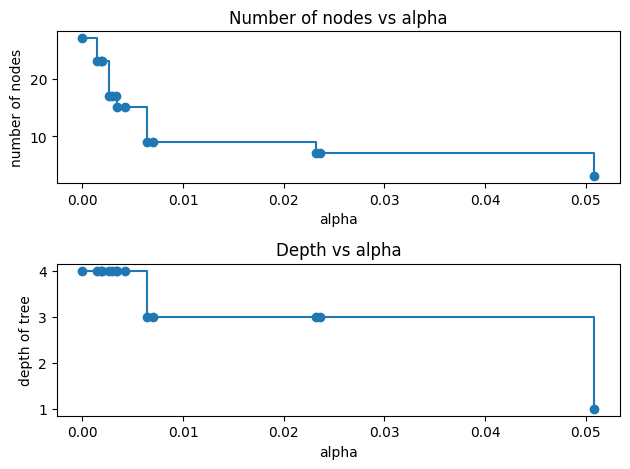

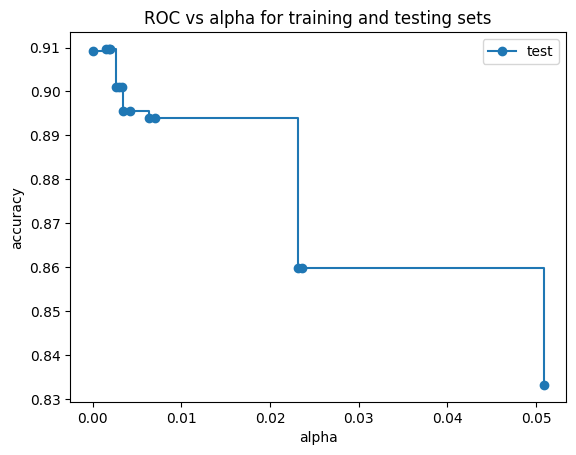

In [135]:
#clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**best_params,random_state=10, ccp_alpha=ccp_alpha,  class_weight='balanced')
    clf.fit(X_train, y_train,  sample_weight = weights )
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores_accuracy = [clf.score(X_train, y_train) for clf in clfs]
test_scores = []

test_scores = [roc_auc_score(y_test[0], clf.predict_proba(X_test)[:, 1]) for clf in clfs]
train_scores = [roc_auc_score(y_train[0], clf.predict_proba(X_train)[:, 1]) for clf in clfs]

train_scores_accuracy = [clf.score(X_train, y_train) for clf in clfs]
test_scores_accuracy  = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("ROC vs alpha for training and testing sets")
#ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

[[ 5142   715]
 [ 4862 18837]]


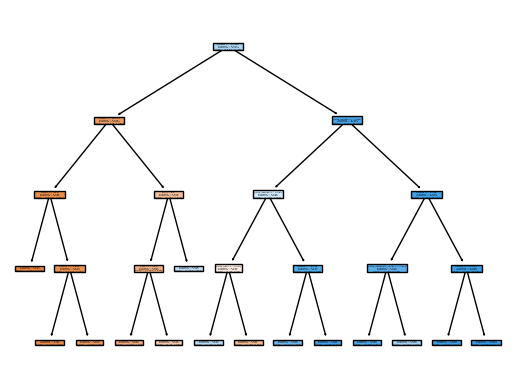

In [136]:
clf_pruned = clfs[train_scores.index(max(train_scores))]

clf_pruned.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf_pruned.predict(X_test)
y_pred_proba = clf_pruned.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print(confusion_matrix(y_test, y_pred))
plot_tree(clf_pruned, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
plt.savefig('Graphs/Full_classifier_3_week_period_pruned.png', dpi = 300)

In [137]:
model_name = f"Full_auroc_{ROC:.4f}_period_pruned.sav"
pickle.dump(clf_pruned, open(model_name, 'wb'))
#clf_pruned = pickle.load(open(model_name, 'rb'))

In [138]:
model_name

'Full_auroc_0.9092_period_pruned.sav'

In [139]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 


Accuracy: 0.8113073487616728
auROC: 0.9091874097110433


In [140]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

sensitivity:  0.7948436642896325
specificity:  0.8779238518012634
ppv:  0.9634308510638298
npv:  0.5139944022391043


Which week drove predictions

In [277]:
weeks_to_predict = range(1,4)
ROC_by_week = []
sensitivity_by_week = []
specificity_by_week = []
ppv_by_week = []
npv_by_week = []

#
for prediction_week in weeks_to_predict: 
    print(prediction_week)
    X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_future = prediction_week,   geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

    X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 122), weeks_in_future = prediction_week,   geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
    weights = weights[0]
    clf_pruned.fit(X_train, y_train,  sample_weight = weights)

    # Make predictions on the test set
    y_pred = clf_pruned.predict(X_test)
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    ROC_by_week.append(roc_auc_score(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)

    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]

    # Calculate specificity (true negative rate)
    specificity_by_week.append(TN / (TN + FP))
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week.append(TP / (TP + FN))

    ppv, npv = calculate_ppv_npv(y_test, y_pred)
    ppv_by_week.append(ppv)
    npv_by_week.append(npv)

1
2
3


# Could skip the next week 

In [107]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_future = 3,   geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 119), weeks_in_future = 3,   geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)


Shift data down one 
No oversampling 

In [108]:
y_train_shifted = y_train.shift(-1)
y_test_shifted = y_test.shift(-1)

y_train_shifted.drop(index=y_train_shifted.index[-1], inplace=True)
y_test_shifted.drop(index=y_test_shifted.index[-1], inplace=True)
X_train.drop(index=X_train.index[-1], inplace=True)
X_test.drop(index=X_test.index[-1], inplace=True)
weights.drop(index=weights.index[-1], inplace=True)
weights = weights[0].to_numpy()

In [109]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf_shifted = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
# Perform Randomized Search with 10-fold cross-validation

best_params = cross_validation_leave_geo_out(all_HSA_ID_weekly_data, geography_column=geography_column, geo_split=geo_split, no_iterations=no_iterations, cv=cv, classifier=clf, param_grid=param_grid, no_iterations_param=100, no_weeks_train=no_weeks_train, no_weeks_test=no_weeks_test, weeks_in_future=weeks_in_future, weight_col=weight_col, keep_output=keep_output, time_period='shifted')


# Create the Decision Tree classifier with the best hyperparameters
clf_shifted = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf_shifted.fit(X_train, y_train_shifted,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf_shifted.predict(X_test)
y_pred_proba = clf_shifted.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_shifted, y_pred)
ROC = roc_auc_score(y_test_shifted, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 

print(confusion_matrix(y_test_shifted, y_pred))
plot_tree(clf_shifted, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
plt.savefig('Graphs/Full_classifier_3_week_period_unpruned.png', dpi = 300)

KeyboardInterrupt: 

In [ ]:
model_name = f"Full_auroc_{ROC:.4f}_shifted_unpruned.sav"
pickle.dump(clf_shifted, open(model_name, 'wb'))


Number of nodes in the last tree is: 1 with ccp_alpha: 0.12129504540983582


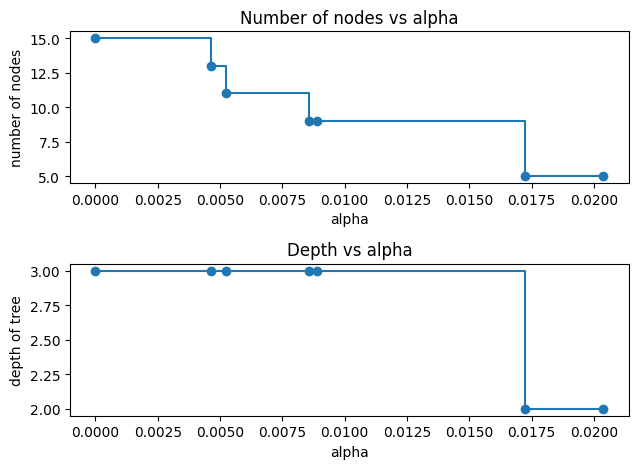

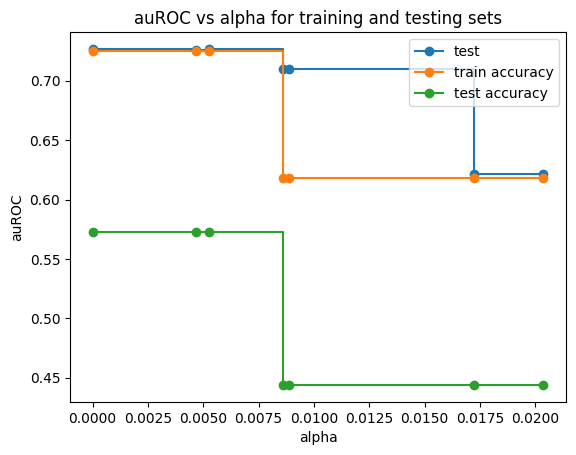

In [39]:
#clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

path = clf_shifted.cost_complexity_pruning_path(X_train, y_train_shifted)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**best_params,random_state=10, ccp_alpha=ccp_alpha,  class_weight='balanced')
    clf.fit(X_train, y_train_shifted,  sample_weight = weights)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

test_scores = []

test_scores = [roc_auc_score(y_test_shifted[0], clf.predict_proba(X_test)[:, 1]) for clf in clfs]

train_scores_accuracy = [clf.score(X_train, y_train_shifted) for clf in clfs]
test_scores_accuracy  = [clf.score(X_test, y_test_shifted) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("auROC")
ax.set_title("auROC vs alpha for training and testing sets")
#ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.plot(ccp_alphas, train_scores_accuracy, marker="o", label="train accuracy", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_accuracy, marker="o", label="test accuracy", drawstyle="steps-post")
ax.legend()
plt.show()

[[ 4744   950]
 [11323 11728]]


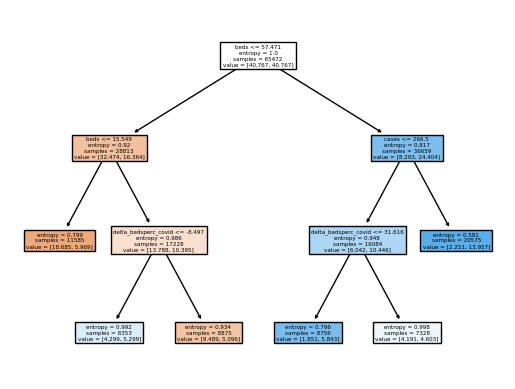

In [41]:
clf_shifted_pruned = clfs[test_scores.index(max(test_scores))]
clf_shifted_pruned.fit(X_train, y_train_shifted,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf_shifted_pruned.predict(X_test)
y_pred_proba = clf_shifted_pruned.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_shifted, y_pred)
ROC = roc_auc_score(y_test_shifted, y_pred_proba[:,1])

print(confusion_matrix(y_test_shifted, y_pred))
plot_tree(clf_shifted_pruned, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
plt.savefig('Graphs/Full_classifier_3_week_period_pruned_shifted.png', dpi = 300)

In [42]:
model_name = f"Full_auroc_{ROC:.4f}_shifted_pruned.sav"
pickle.dump(clf_shifted_pruned, open(model_name, 'wb'))
#clf = pickle.load(open(model_name, 'rb'))
#clf

In [25]:
accuracy = accuracy_score(y_test_shifted, y_pred)
print('accuracy: ', accuracy)
conf_matrix = confusion_matrix(y_test_shifted, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

accuracy:  0.5730387893546703
sensitivity:  0.5087848683354301
specificity:  0.8331577098700387
ppv:  0.92506704527528
npv:  0.2952635837430759


# Exactly 3 week prediction

In [45]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_future = 3,   geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future = 3,   geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0].to_numpy()

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 20, 2),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=50, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)
# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
plt.savefig('Graphs/Full_classifier_3_week_exact_unpruned.png', dpi = 300)

In [47]:
# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)
# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

In [48]:
model_name = f"Full_auroc_{ROC:.4f}_exact_unpruned.sav"
pickle.dump(clf, open(model_name, 'wb'))
#clf = pickle.load(open(model_name, 'rb'))

In [49]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

sensitivity:  0.7204042829980987
specificity:  0.8449547082367811
ppv:  0.9072463768115943
npv:  0.5894195444526084


Number of nodes in the last tree is: 3 with ccp_alpha: 0.19722281993446744


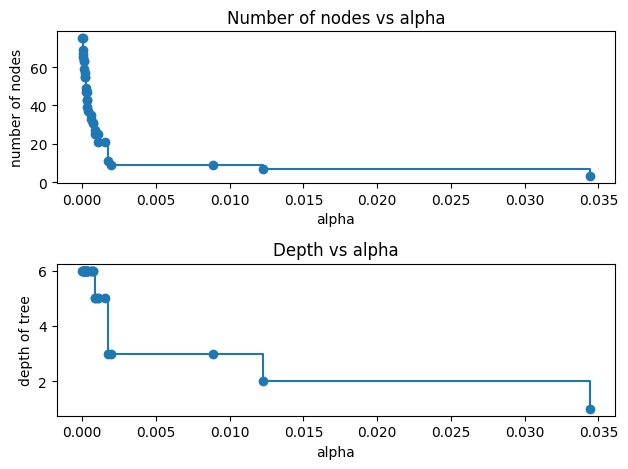

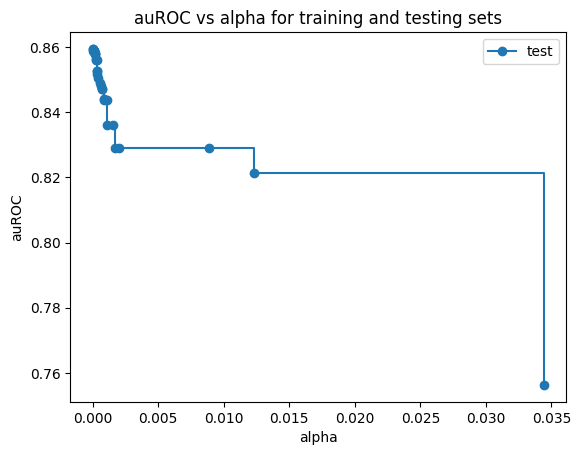

In [52]:

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**best_params,random_state=10, ccp_alpha=ccp_alpha,  class_weight='balanced')
    clf.fit(X_train, y_train,  sample_weight = weights)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
test_scores = [roc_auc_score(y_test[0], clf.predict_proba(X_test)[:, 1]) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("auROC")
ax.set_title("auROC vs alpha for training and testing sets")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Accuracy: 0.7605156037991859
auROC: 0.8594086800300973
[[ 8022  1472]
 [ 5588 14398]]


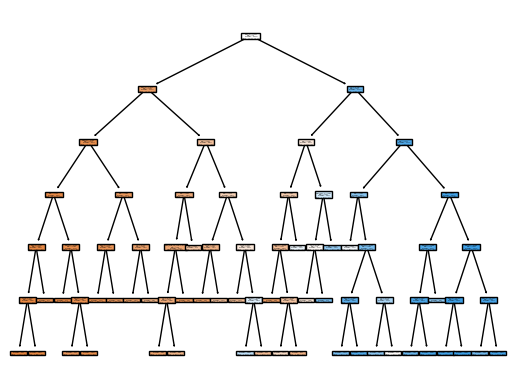

In [55]:
clf_pruned = clfs[test_scores.index(max(test_scores))]
clf_pruned.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf_pruned.predict(X_test)
y_pred_proba = clf_pruned.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 

print(confusion_matrix(y_test, y_pred))
plot_tree(clf_pruned, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
plt.savefig('Graphs/Full_classifier_3_week_exact_pruned.png', dpi = 300)

In [56]:
model_name = f"Full_auroc_{ROC:.4f}_exact_pruned.sav"
pickle.dump(clf_pruned, open(model_name, 'wb'))
#clf = pickle.load(open(model_name, 'rb'))

In [57]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

sensitivity:  0.7204042829980987
specificity:  0.8449547082367811
ppv:  0.9072463768115943
npv:  0.5894195444526084


## Restricting the number of levels for a classifier

Period classifier

In [17]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_future = 3,   geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future = 3,   geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0].to_numpy()

Accuracy: 0.7655698778833108
auROC: 0.9051746741154725
[[ 5467   380]
 [ 6531 17102]]
accuracy:  0.7655698778833108
sensitivity:  0.7236491346845513
specificity:  0.9350094065332649
ppv:  0.9782633565953552
npv:  0.455659276546091


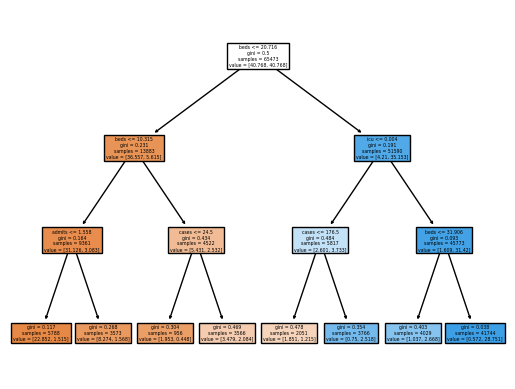

In [73]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
no_weeks_train =  range(1, int(26) + 1)  # First 6 months initially 
no_weeks_test = range(26, int(26 + 13) + 1)  # Next three months
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  
no_iterations_param = 10  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 6),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
# Perform Randomized Search with 10-fold cross-validation

best_params = cross_validation_leave_geo_out(all_HSA_ID_weekly_data, geography_column=geography_column, geo_split=geo_split, no_iterations=no_iterations, cv=cv, classifier=clf, param_grid=param_grid, no_iterations_param=no_iterations_param, no_weeks_train=no_weeks_train, no_weeks_test=no_weeks_test, weeks_in_future=weeks_in_future, weight_col=weight_col, keep_output=keep_output, time_period='period')


# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Make predictions on the test set
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
#plt.savefig('Graphs/Restricted/Full_classifier_3_week_period_restricted.png', dpi = 300)

print('accuracy: ', accuracy)
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)


In [27]:
def simplify_labels_graphviz(graph):
        for node in graph.get_node_list():
                if node.get_attributes().get('label') is None:
                    continue
                else:
                    split_label = node.get_attributes().get('label').split('<br/>')
                    if len(split_label) == 4:
                        split_label[3]  =  split_label[3].split('=')[1].strip()

                        del(split_label[1])  # number of samples
                        del(split_label[1])  # split of sample
                    elif len(split_label) == 3:  # for a terminating node, no rule is provided
                        split_label[2]  =  split_label[2].split('=')[1].strip()


                        del(split_label[0])  # number of samples
                        del(split_label[0])  # split of samples
                        split_label[0] = '<' + split_label[0]
                    node.set('label', '<br/>'.join(split_label))

In [29]:
import pydotplus
from six import StringIO 
from IPython.display import Image
import matplotlib.pyplot as plt
import string
import numpy as np
from PIL import Image

In [34]:
feature_names=['Cases','\u0394 Cases', 'Deaths', '\u0394 Deaths', 'Admissions', '\u0394 Admissions', 'ICU', '\u0394 ICU',  'Beds', '\u0394 Beds', 'Percent of beds', '\u0394 Perc. beds', 'Hospital capacity exceeded']

In [35]:
dot_data = StringIO()
tree.export_graphviz(clf, 
 out_file=dot_data, 
 class_names=['Over', 'Under'], # the target names.
 feature_names= feature_names, # the feature names.
 filled=True, # Whether to fill in the boxes with colours.
 rounded=True, # Whether to round the corners of the boxes.
 special_characters=True, 
 proportion=False,
 precision = 3, 
 impurity=False)

graph_shifted_full = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
simplify_labels_graphviz(graph_shifted_full)
graph_shifted_full.write_png(f'Full_classifier_3_week_restricted_simplified.png')  # Save the graph as PNG

True

In [ ]:
weeks_to_predict = range(1, 121 - 13 - 3 - 26)
ROC_by_week_full_period = []
sensitivity_by_week_full_period = []
specificity_by_week_full_period = []
ppv_by_week_full_period = []
npv_by_week_full_period = []
accuracy_by_week_full_period = []

for prediction_week in weeks_to_predict:
    print(prediction_week)
    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + 13) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()
    best_params = cross_validation_leave_geo_out(HSA_weekly_data_all, geography_column=geography_column, geo_split=geo_split, no_iterations=no_iterations, cv=cv, classifier=clf_full_period, param_grid=param_grid, no_iterations_param=no_iterations_param, no_weeks_train=no_weeks_train, no_weeks_test=no_weeks_test, weeks_in_future=weeks_in_future, weight_col=weight_col, keep_output=keep_output, time_period='period')
    clf_full_period = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model
    accuracy_by_week_full_period.append(accuracy_score(y_test_full_period, y_pred))
    ROC_by_week_full_period.append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_full_period, y_pred)

    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]

    # Calculate specificity (true negative rate)
    specificity_by_week_full_period.append(TN / (TN + FP))
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week_full_period.append(TP / (TP + FN))
    model_name_to_save = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"

    pickle.dump(clf_full_period, open(model_name_to_save, 'wb'))
    ppv, npv = calculate_ppv_npv(conf_matrix)
    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


Exact time 

In [69]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_future = 3,   geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future = 3,   geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0].to_numpy()

Accuracy: 0.8027476255088195
auROC: 0.9140988874894558
[[ 5257   590]
 [ 5225 18408]]
accuracy:  0.8027476255088195
sensitivity:  0.7789108450048661
specificity:  0.8990935522490165
ppv:  0.968944099378882
npv:  0.5015264262545316


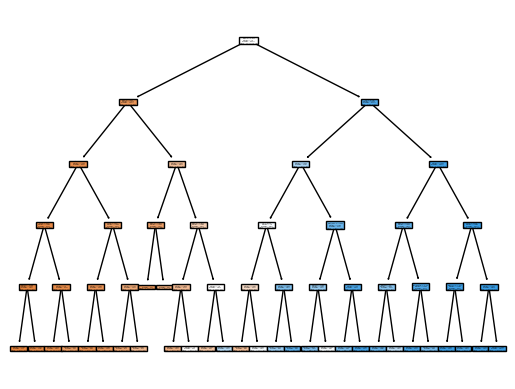

In [75]:
param_grid = {
    'criterion': ['gini',  'entropy'],
    'max_depth': np.arange(2, 6),
    'min_samples_split':  np.arange(100, 1000, 20), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(100, 1000, 20)} #100, 200, 300, 400, 500], #np.arange(500, 200)}

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 


print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
plt.savefig('Graphs/Restricted/Full_classifier_3_week_exact_restricted.png', dpi = 300)

print('accuracy: ', accuracy)
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

In [20]:
best_params = 
{'min_samples_split': 680,
 'min_samples_leaf': 660,
 'max_depth': 2,
 'criterion': 'gini'}
Accuracy: 0.712516960651289
auROC: 0.7561268609534996
[[ 8342  1152]
 [ 7323 12663]]
accuracy:  0.712516960651289
sensitivity:  0.6335935154608225
specificity:  0.8786602064461765
ppv:  0.9166123778501629
npv:  0.5325247366741143

{'min_samples_split': 680,
 'min_samples_leaf': 660,
 'max_depth': 2,
 'criterion': 'gini'}

Accuracy: 0.796370420624152
auROC: 0.8869778630092391
[[ 5223   624]
 [ 5379 18254]]
accuracy:  0.796370420624152
sensitivity:  0.7723945330681674
specificity:  0.8932786044125193
ppv:  0.9669456510223541
npv:  0.4926428975664969


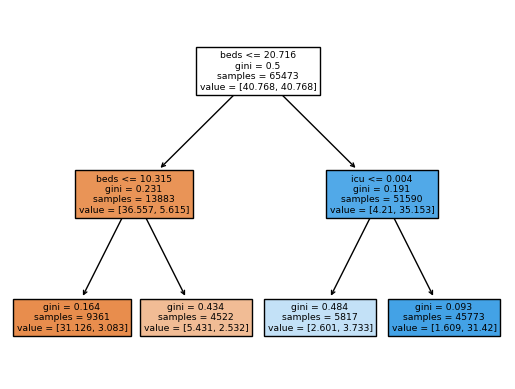

In [26]:

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 


print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
#plt.savefig('Graphs/Restricted/Full_classifier_3_week_exact_restricted.png', dpi = 300)

print('accuracy: ', accuracy)
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

# Use CV to get best alpha value

In [73]:
model_name = f"CDC_full_auroc_0.8390_period_unpruned.sav"
#pickle.dump(clf, open(model_name, 'wb'))
clf = pickle.load(open(model_name, 'rb'))

In [74]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_future = 3,   geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future = 3,   geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0].to_numpy()

In [76]:

# Load and prepare data (X_train, y_train assumed to be defined)

# Create an unpruned tree
#unpruned_tree = pickle.load(open(model_name, 'rb'))
unpruned_tree = clf
# Calculate impurity-based CCP alphas
path = unpruned_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Perform cross-validation for different alpha values
best_alpha = None
best_score = 0
for alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(ccp_alpha=alpha)
    scores = cross_val_score(pruned_tree, X_train, y_train, cv=cv)  # Use your desired cross-validation strategy
    mean_score = np.mean(scores)
    
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

print("Best alpha:", best_alpha)

KeyboardInterrupt: 

Accuracy: 0.796370420624152
auROC: 0.8519262267092659
[[ 5223   624]
 [ 5379 18254]]


[Text(0.4, 0.8333333333333334, 'beds <= 20.716\ngini = 0.5\nsamples = 65473\nvalue = [40.768, 40.768]'),
 Text(0.2, 0.5, 'gini = 0.231\nsamples = 13883\nvalue = [36.557, 5.615]'),
 Text(0.6, 0.5, 'icu <= 0.004\ngini = 0.191\nsamples = 51590\nvalue = [4.21, 35.153]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.484\nsamples = 5817\nvalue = [2.601, 3.733]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.093\nsamples = 45773\nvalue = [1.609, 31.42]')]

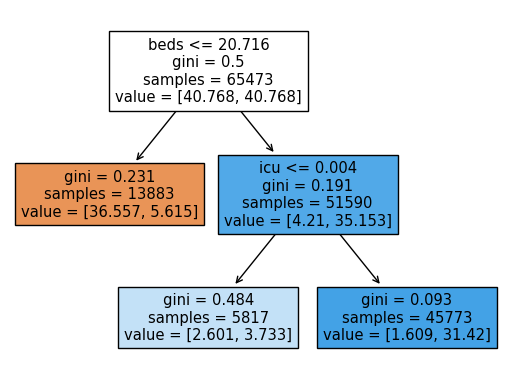

In [23]:
# Train the decision tree classifier
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced', ccp_alpha = 0.008222701863035212)

clf.fit(X_train, y_train,  sample_weight = weights)

# Make clf on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 


print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
#plt.savefig('Graphs/Restricted/Full_classifier_3_week_exact_restricted.png', dpi = 300)


In [89]:
clf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=480, min_samples_split=540,
                       random_state=10, ccp_alpha= best_alpha)

In [90]:
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf_shifted.predict(X_test)
y_pred_proba = clf_shifted.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_shifted, y_pred)
ROC = roc_auc_score(y_test_shifted, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 

Accuracy: 0.8027476255088195
ROC: 0.8390021986269413


[Text(0.46875, 0.9166666666666666, 'beds <= 21.424\nentropy = 1.0\nsamples = 65473\nvalue = [40.768, 40.768]'),
 Text(0.22321428571428573, 0.75, 'beds <= 9.994\nentropy = 0.576\nsamples = 14220\nvalue = [36.748, 5.827]'),
 Text(0.13392857142857142, 0.5833333333333334, 'admits <= 1.558\nentropy = 0.433\nsamples = 9217\nvalue = [30.846, 3.014]'),
 Text(0.07142857142857142, 0.4166666666666667, 'cases <= 24.5\nentropy = 0.335\nsamples = 5749\nvalue = [22.75, 1.499]'),
 Text(0.03571428571428571, 0.25, 'deaths <= 0.308\nentropy = 0.221\nsamples = 1957\nvalue = [9.305, 0.341]'),
 Text(0.017857142857142856, 0.08333333333333333, 'entropy = 0.152\nsamples = 771\nvalue = [4.064, 0.091]'),
 Text(0.05357142857142857, 0.08333333333333333, 'entropy = 0.267\nsamples = 1186\nvalue = [5.241, 0.25]'),
 Text(0.10714285714285714, 0.25, 'cases <= 132.5\nentropy = 0.4\nsamples = 3792\nvalue = [13.445, 1.158]'),
 Text(0.08928571428571429, 0.08333333333333333, 'entropy = 0.368\nsamples = 2796\nvalue = [10.456,

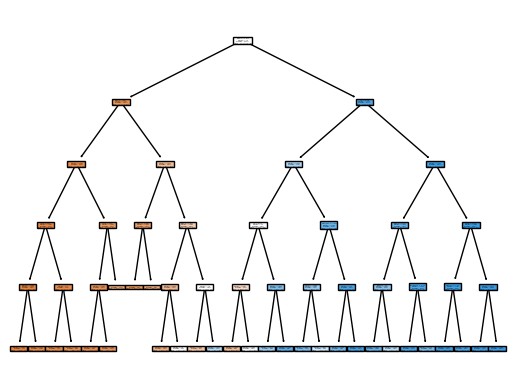

In [91]:
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)


In [55]:
all_HSA_ID_weekly_data.to_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv')
